# Example Usage

In this notebook, we show example of how to use our hybrid training procedure to train GP on the 2D banana data set.

We train a full GP in the `Approximate inference in full GP` section and the sparse GP in the `Approximate inference in sparse GP`.

In the E step, we use natural gradient descent to infer variational parameters. In the M step, we use the EP estimation of marginal likelihood as the training objective and use Adam optimizer to learn hyperparameters.

In [1]:
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from gpflow import set_trainable
from gpflow.optimizers import NaturalGradient
from scipy.stats import multinomial
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../')
from src.tvgp import t_VGP
from src.tsvgp import t_SVGP

from src.new_bernoulli.logphi import NewProbitBernoulli

2023-06-14 16:10:21.582683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 16:10:28.352479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /scratch/work/lir3/.conda_envs/GP/lib
2023-06-14 16:10:28.352519: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-14 16:10:28.823055: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-14 1

## Load banana dataset

400 data points in total in banana data set


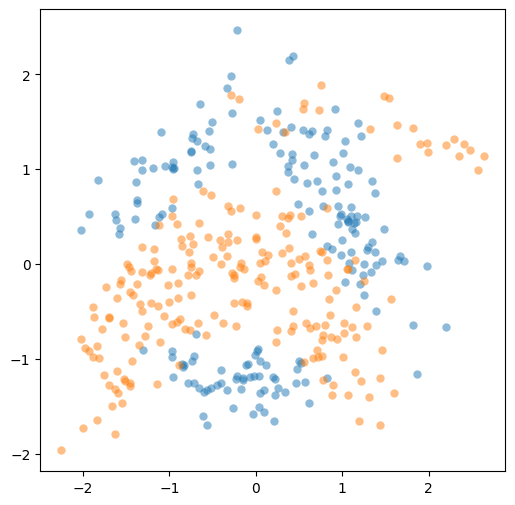

In [2]:
X = np.loadtxt("toy_data/banana_X_train", delimiter=",")
Y = np.loadtxt("toy_data/banana_Y_train", delimiter=",").reshape(-1, 1)
## NewBernoulli only support {-1,1}
Y[np.where(Y == 0)] = -1

mask = Y[:, 0] == -1
N = len(Y)
print(f"{N} data points in total in banana data set")

plt.figure(figsize=(6, 6))
plt.plot(X[mask, 0], X[mask, 1], "oC0", mew=0, alpha=0.5)
_ = plt.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], "oC1", mew=0, alpha=0.5)
plt.show()


# split data into training and test set
X_train, X_test, Y_train, Y_test=train_test_split(X, Y,test_size=0.25,random_state=42) 

## Set training iterations, the number of E steps and M steps in each iteration

In [3]:
iterations = 30
E_steps = 20
M_steps = 20

## Approximate inference in full GP

### Define model

In [4]:
model = t_VGP(
                    data=(X_train, Y_train),
                    kernel=gpflow.kernels.Matern52(variance=1., lengthscales=1.),
                    likelihood=NewProbitBernoulli(),
                )

### VEM training

In [5]:
ep_energy = []
# log initial ep energy
ep_energy.append(model.ep_estimation().numpy())

optimizer = tf.optimizers.Adam(0.01)

for step in range(iterations):
    
    if step % 5 == 0:

        print(f"step {step}, elbo {model.elbo().numpy()}, ep energy {model.ep_estimation().numpy()}")
    
    # log variable values for convergence evaluation
    old_variables = gpflow.optimizers.Scipy.pack_tensors(model.variables).numpy()
    old_params = gpflow.utilities.deepcopy(gpflow.utilities.parameter_dict(model))

    ####################### E step  #######################
    for _ in range(E_steps):
        model.update_variational_parameters(beta=0.1)

    ####################### M step #######################
    set_trainable(model.sites.lambda_1, False)
    set_trainable(model.sites.lambda_2, False)

    for _ in range(M_steps):
        optimizer.minimize(lambda: -model.ep_estimation(), model.trainable_variables)
        
    ####################### convergence check #######################
    
    ep_energy.append(model.ep_estimation().numpy())
    new_variables = gpflow.optimizers.Scipy.pack_tensors(model.variables).numpy()
    new_params = gpflow.utilities.deepcopy(gpflow.utilities.parameter_dict(model))

    ep_diff = ep_energy[-1] - ep_energy[-2]

    if np.allclose(old_variables, new_variables) or ep_diff < 0:
        gpflow.utilities.multiple_assign(model, old_params)
        break

    else:
        old_variables = new_variables
        old_params = new_params

step 0, elbo -299.995707328502, ep energy -207.94415417158697
step 5, elbo -97.13005945824935, ep energy -97.06948944915094
step 10, elbo -94.14991106372909, ep energy -94.05804336463468
step 15, elbo -92.43590332962916, ep energy -92.32317446369616
step 20, elbo -91.32924246976467, ep energy -91.19931922705632
step 25, elbo -90.5567362020779, ep energy -90.41244159716155


### Evaluation on test set

In [6]:
m, v = model.predict_y(X_test)
p = np.concatenate([1 - m, m], 1)

Y_test[np.where(Y_test == -1)] = 0
Y_test_one_hot = np.eye(2)[Y_test.flatten().astype(int)].reshape(Y_test.shape[:-1] + (2,)) 

test_loglik = np.mean(multinomial.logpmf(Y_test_one_hot, n = 1, p = p))

pred = np.argmax(p, axis = -1)
test_acc = np.mean(np.array(pred == Y_test.flatten()).astype(float))

print(f"test set: log predictive density {test_loglik}, accuracy {test_acc}")

test set: log predictive density -0.2420959132194972, accuracy 0.93


## Approximate inference in sparse GP

### Define model

In [7]:
Z = X_train[:20]

model = t_SVGP(
                kernel=gpflow.kernels.Matern52(variance=1., lengthscales=1.), 
                likelihood=NewProbitBernoulli(), 
                inducing_variable=Z,
            )

set_trainable(model.inducing_variable.Z, False)

### VEM training

In [8]:
data = (X_train, Y_train)

ep_energy = []
# log initial ep energy
ep_energy.append(model.ep_estimation(data).numpy())

optimizer = tf.optimizers.Adam(0.01)

for step in range(iterations):
    
    print(f"step {step}, elbo {model.elbo(data).numpy()}, ep energy {model.ep_estimation(data).numpy()}")
    
    # log variable values for convergence evaluation
    old_variables = gpflow.optimizers.Scipy.pack_tensors(model.variables).numpy()
    old_params = gpflow.utilities.deepcopy(gpflow.utilities.parameter_dict(model))

    ####################### E step  #######################
    for _ in range(E_steps):
        model.natgrad_step(data, 0.1)

    ####################### M step #######################
    set_trainable(model.sites.lambda_1, False)
    set_trainable(model.sites.lambda_2_sqrt, False)

    for _ in range(M_steps):
        optimizer.minimize(lambda: -model.ep_estimation(data), model.trainable_variables)
        
    ####################### convergence check #######################
    
    ep_energy.append(model.ep_estimation(data).numpy())
    new_variables = gpflow.optimizers.Scipy.pack_tensors(model.variables).numpy()
    new_params = gpflow.utilities.deepcopy(gpflow.utilities.parameter_dict(model))

    ep_diff = ep_energy[-1] - ep_energy[-2]


    if np.allclose(old_variables, new_variables) or ep_diff < 0:
        gpflow.utilities.multiple_assign(model, old_params)
        break

    else:
        old_variables = new_variables
        old_params = new_params

step 0, elbo -299.99999998133114, ep energy -203.13975110486228
step 1, elbo -123.60318418051212, ep energy -120.38299159804777
step 2, elbo -123.88119445801023, ep energy -109.60961414180908
step 3, elbo -125.06754844044904, ep energy -109.48472428972005


### evaluation

In [9]:
m, v = model.predict_y(X_test)
p = np.concatenate([1 - m, m], 1)

test_loglik = np.mean(multinomial.logpmf(Y_test_one_hot, n = 1, p = p))

pred = np.argmax(p, axis = -1)
test_acc = np.mean(np.array(pred == Y_test.flatten()).astype(float))

print(f"test set: log predictive density {test_loglik}, accuracy {test_acc}")

test set: log predictive density -0.3049051019927772, accuracy 0.9
